In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Syn-training.parquet
/kaggle/input/UDPLag-testing.parquet
/kaggle/input/NetBIOS-testing.parquet
/kaggle/input/Portmap-training.parquet
/kaggle/input/Syn-testing.parquet
/kaggle/input/MSSQL-testing.parquet
/kaggle/input/SNMP-testing.parquet
/kaggle/input/UDPLag-training.parquet
/kaggle/input/NTP-testing.parquet
/kaggle/input/LDAP-testing.parquet
/kaggle/input/UDP-training.parquet
/kaggle/input/NetBIOS-training.parquet
/kaggle/input/DNS-testing.parquet
/kaggle/input/UDP-testing.parquet
/kaggle/input/LDAP-training.parquet
/kaggle/input/TFTP-testing.parquet
/kaggle/input/MSSQL-training.parquet


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, LeakyReLU, BatchNormalization, Dropout, Bidirectional, GRU, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import os

2025-05-18 16:45:26.642548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747586726.666222     125 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747586726.673286     125 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
dataset_paths = {
    "dns_testing": "/kaggle/input/DNS-testing.parquet",
    "ldap_testing": "/kaggle/input/LDAP-testing.parquet",
    "ldap_training": "/kaggle/input/LDAP-training.parquet",
    "mssql_testing": "/kaggle/input/MSSQL-testing.parquet",
    "mssql_training": "/kaggle/input/MSSQL-training.parquet",
    "ntp_testing": "/kaggle/input/NTP-testing.parquet",
    "netbios_training": "/kaggle/input/NetBIOS-training.parquet",
    "netbios_testing": "/kaggle/input/NetBIOS-testing.parquet",
    "portmap_training": "/kaggle/input/Portmap-training.parquet",
    "snmp_testing": "/kaggle/input/SNMP-testing.parquet",
    "syn_testing": "/kaggle/input/Syn-testing.parquet",
    "syn_training": "/kaggle/input/Syn-training.parquet",
    "tftp_testing": "/kaggle/input/TFTP-testing.parquet",
    "udp_testing": "/kaggle/input/UDP-testing.parquet",
    "udp_training": "/kaggle/input/UDP-training.parquet",
    "udplag_testing": "/kaggle/input/UDPLag-testing.parquet",
    "udplag_training": "/kaggle/input/UDPLag-training.parquet"
}

In [5]:
# Print available files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/Syn-training.parquet
/kaggle/input/UDPLag-testing.parquet
/kaggle/input/NetBIOS-testing.parquet
/kaggle/input/Portmap-training.parquet
/kaggle/input/Syn-testing.parquet
/kaggle/input/MSSQL-testing.parquet
/kaggle/input/SNMP-testing.parquet
/kaggle/input/UDPLag-training.parquet
/kaggle/input/NTP-testing.parquet
/kaggle/input/LDAP-testing.parquet
/kaggle/input/UDP-training.parquet
/kaggle/input/NetBIOS-training.parquet
/kaggle/input/DNS-testing.parquet
/kaggle/input/UDP-testing.parquet
/kaggle/input/LDAP-training.parquet
/kaggle/input/TFTP-testing.parquet
/kaggle/input/MSSQL-training.parquet


In [6]:
# Data preparation
print("Loading datasets...")
dataframes = {name: pd.read_parquet(path) for name, path in dataset_paths.items()}
dataframes_list = list(dataframes.items())


Loading datasets...


In [7]:
# Check column consistency across datasets
reference_name, reference_df = dataframes_list[0]
reference_columns = set(reference_df.columns)

for name, df in dataframes_list:
    if set(df.columns) != reference_columns:
        print(f"Warning: DataFrame {name} has different columns")
        print(f"Different columns: {set(df.columns) - reference_columns} | {reference_columns - set(df.columns)}")


In [8]:
label_mapping = {
    'LDAP': 'DrDoS_LDAP',
    'MSSQL': 'DrDoS_MSSQL',
    'NetBIOS': 'DrDoS_NetBIOS',
    'UDP-lag': 'DDoS_UDP_Lag',
    'UDPLag': 'DDoS_UDP_Lag',
    'UDP': 'DDoS_UDP',
    'Syn': 'DDoS_SYN',
    'Portmap': 'DrDoS_Portmap',
    'TFTP': 'DrDoS_TFTP',
    'WebDDoS': 'DDoS_Web'
}

In [9]:
for name, df in dataframes.items():
    df['Label'] = df['Label'].map(lambda x: label_mapping.get(x, x))

# Combine datasets
combined_datasets = {}
for name, df in dataframes_list:
    base_name = name.split('_')[0]
    if base_name not in combined_datasets:
        combined_datasets[base_name] = df
    else:
        combined_datasets[base_name] = pd.concat([combined_datasets[base_name], df], ignore_index=True)

df = pd.concat(combined_datasets.values(), ignore_index=True)


In [10]:
# Data cleaning
print("Data cleaning...")
print(f"Original shape: {df.shape}")
print(f"Found {df.duplicated().sum()} duplicate rows")
df = df.drop_duplicates().reset_index(drop=True)


Data cleaning...
Original shape: (431371, 78)
Found 8568 duplicate rows


In [11]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Columns with missing values: {missing_values[missing_values > 0]}")
df = df.dropna().reset_index(drop=True)


Columns with missing values: Series([], dtype: int64)


In [12]:
# Find columns with float data types
float_columns = df.select_dtypes(include=['float64', 'float32']).columns


In [13]:
# Count rows with infinite values before replacement
inf_mask = np.isinf(df[float_columns].values).any(axis=1)
print(f"Found {inf_mask.sum()} rows with infinite values")


Found 0 rows with infinite values


In [14]:
# Remove rows with infinite values
inf_mask = np.isinf(df.select_dtypes(include=['float64', 'float32']).values).any(axis=1)
print(f"Found {inf_mask.sum()} rows with infinite values")
df = df[~inf_mask].reset_index(drop=True)

Found 0 rows with infinite values


In [15]:
print(f"Clean shape: {df.shape}")


Clean shape: (422803, 78)


In [16]:
# Get feature columns
feature_cols = [col for col in df.columns if col != 'Label']
feature_cols


['Protocol',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Fwd Packets Length Total',
 'Bwd Packets Length Total',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Packet Length Min',
 'Packet Length Max',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',

In [17]:
# Handle outliers
def handle_outliers(df, columns):
    df_out = df.copy()
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers rather than removing them
        df_out[col] = np.where(df_out[col] < lower_bound, lower_bound, df_out[col])
        df_out[col] = np.where(df_out[col] > upper_bound, upper_bound, df_out[col])
    return df_out


In [18]:
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')


In [19]:
print("Normalizing features...")
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])



Normalizing features...


In [20]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [21]:
print("Encoding labels...")
# First, create a binary label for benign vs. attack
df['is_attack'] = (df['Label'] != 'Benign').astype(int)

# Then encode the detailed attack types
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])



Encoding labels...


In [22]:
df['Label'].unique()


array(['DrDoS_DNS', 'Benign', 'DrDoS_LDAP', 'DrDoS_NetBIOS',
       'DrDoS_MSSQL', 'DrDoS_NTP', 'DrDoS_Portmap', 'DrDoS_SNMP',
       'DDoS_SYN', 'DrDoS_TFTP', 'DrDoS_UDP', 'DDoS_UDP', 'DDoS_UDP_Lag',
       'DDoS_Web'], dtype=object)

In [23]:
# %%
df['is_attack'].unique()
# 1 for attack 0 for benign


array([1, 0])

In [24]:
df['Label_encoded'].unique()


array([ 5,  0,  6,  9,  7,  8, 10, 11,  1, 12, 13,  2,  3,  4])

In [25]:
# Print label mapping
label_mapping_df = pd.DataFrame({
    'Original Label': label_encoder.classes_,
    'Encoded Value': range(len(label_encoder.classes_))
})
print("Label mapping:")
print(label_mapping_df)

Label mapping:
   Original Label  Encoded Value
0          Benign              0
1        DDoS_SYN              1
2        DDoS_UDP              2
3    DDoS_UDP_Lag              3
4        DDoS_Web              4
5       DrDoS_DNS              5
6      DrDoS_LDAP              6
7     DrDoS_MSSQL              7
8       DrDoS_NTP              8
9   DrDoS_NetBIOS              9
10  DrDoS_Portmap             10
11     DrDoS_SNMP             11
12     DrDoS_TFTP             12
13      DrDoS_UDP             13


In [26]:
n_classes = len(label_encoder.classes_)
print(f"Number of classes: {n_classes}")


Number of classes: 14


In [28]:
# Prepare X and y
X = df[feature_cols].values
y_binary = df['is_attack'].values
y_multiclass = df['Label_encoded'].values
y_onehot = to_categorical(y_multiclass, num_classes=n_classes)


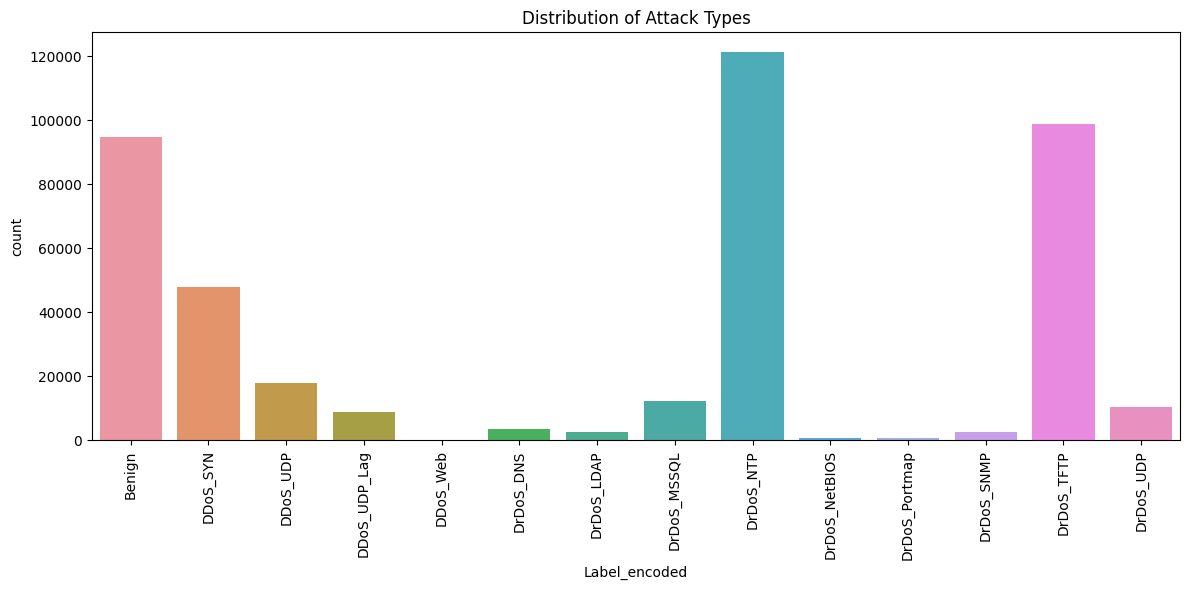

In [27]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Label_encoded', data=df)
plt.title('Distribution of Attack Types')
plt.xticks(range(n_classes), label_encoder.classes_, rotation=90)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

In [29]:
X_train, X_test, y_train_multi, y_test_multi, y_train_binary, y_test_binary = train_test_split(
    X, y_multiclass, y_binary, test_size=0.25, random_state=42, stratify=y_multiclass
)

In [30]:
# %%
y_train_onehot = to_categorical(y_train_multi, num_classes=n_classes)
y_test_onehot = to_categorical(y_test_multi, num_classes=n_classes)


In [31]:
# %%
# For autoencoder - select only benign traffic
benign_idx = np.where(y_train_binary == 0)[0]
X_train_benign = X_train[benign_idx]

In [32]:
# %%
# Reshape input data for LSTM (samples, time steps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train_benign_reshaped = X_train_benign.reshape(X_train_benign.shape[0], 1, X_train_benign.shape[1])


In [33]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Benign training data shape: {X_train_benign.shape}")

Training data shape: (317102, 77)
Test data shape: (105701, 77)
Benign training data shape: (71028, 77)


In [34]:
def create_autoencoder(input_shape, encoding_dim=128, l2_reg=0.001, dropout_rate=0.3):
    # Input
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = LSTM(256, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = LSTM(encoding_dim, activation='relu', return_sequences=False,
             kernel_regularizer=regularizers.l2(l2_reg))(x)
    encoded = BatchNormalization()(x)
     # Decoder
    x = RepeatVector(input_shape[0])(encoded)
    
    x = LSTM(encoding_dim, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = LSTM(256, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
     # Output
    outputs = TimeDistributed(Dense(input_shape[1]))(x)
        # Create the model
    autoencoder = Model(inputs=inputs, outputs=outputs, name="autoencoder")
    
    # Create encoder model
    encoder = Model(inputs=inputs, outputs=encoded, name="encoder")
    
    return autoencoder, encoder


In [35]:
# Create a classification neural network for attack type prediction
def create_classifier(input_dim, num_classes, hidden_layers=[256, 128], dropout_rate=0.3):
    model = Sequential()
    
    # First layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
       # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model
    

In [36]:
# Compile and train the autoencoder (on benign data only)
print("Training autoencoder on benign data only...")
input_shape = (X_train_benign_reshaped.shape[1], X_train_benign_reshaped.shape[2])  # (time steps, features)
autoencoder, encoder = create_autoencoder(
    input_shape=input_shape,
    encoding_dim=128,
    l2_reg=0.001,
    dropout_rate=0.3
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mae', metrics=['mse'])
autoencoder.summary()


Training autoencoder on benign data only...


I0000 00:00:1747586739.325480     125 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747586739.326202     125 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 77)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 256)              │         342,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 77)               │          19,789 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,087,821 (4.15 MB)

 Trainable params: 1,086,285 (4.14 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [37]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_autoencoder_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]


In [38]:
print(f"Training autoencoder on {X_train_benign_reshaped.shape[0]} benign samples...")
history_autoencoder = autoencoder.fit(
    X_train_benign_reshaped, X_train_benign_reshaped, 
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Training autoencoder on 71028 benign samples...
Epoch 1/50


I0000 00:00:1747586751.488696     180 service.cc:148] XLA service 0x4f91b530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747586751.489989     180 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747586751.490011     180 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747586752.668945     180 cuda_dnn.cc:529] Loaded cuDNN version 90300


 38/222 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3332 - mse: 0.8153 

I0000 00:00:1747586756.641642     180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7085 - mse: 0.3298
Epoch 1: val_loss improved from inf to 0.10427, saving model to best_autoencoder_model.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.7070 - mse: 0.3289 - val_loss: 0.1043 - val_mse: 0.0180 - learning_rate: 0.0010
Epoch 2/50
215/222 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0770 - mse: 0.0096
Epoch 2: val_loss improved from 0.10427 to 0.05942, saving model to best_autoencoder_model.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0766 - mse: 0.0095 - val_loss: 0.0594 - val_mse: 0.0161 - learning_rate: 0.0010
Epoch 3/50
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413 - mse: 0.0068
Epoch 3: val_loss improved from 0.05942 to 0.04048, saving model to best_autoencoder_model.keras
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0412 - mse: 0.0068 - val_loss: 0.0405 - val_mse: 0.0099 - learning_rate: 0.0010
Epoch 4/50
210/222 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 - mse: 0.0068
Epoc

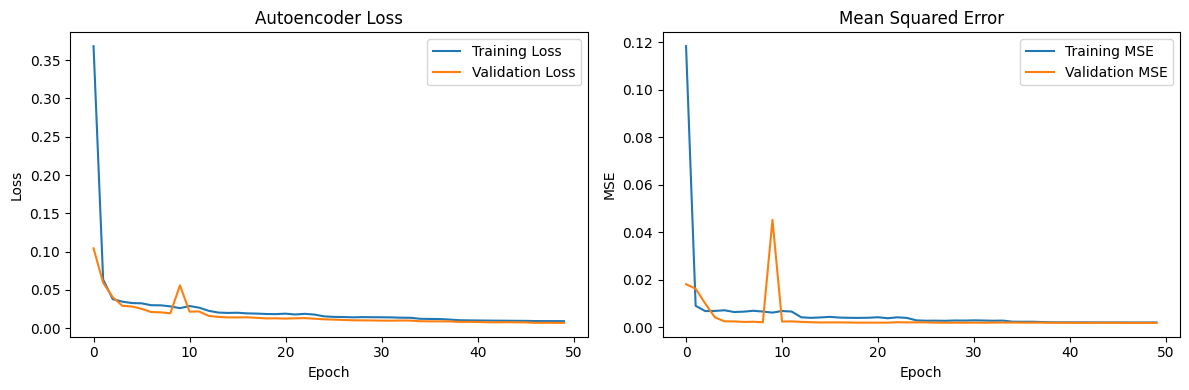

In [39]:
# Visualize training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_autoencoder.history['mse'], label='Training MSE')
plt.plot(history_autoencoder.history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.savefig('autoencoder_training_history.png')
plt.show()


In [40]:
# Calculate reconstruction errors
print("Calculating reconstruction errors...")
start_time = time.time()

Calculating reconstruction errors...


In [41]:
# Get reconstruction errors for all data
X_train_pred = autoencoder.predict(X_train_reshaped)
X_test_pred = autoencoder.predict(X_test_reshaped)

9910/9910 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
3304/3304 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [42]:
# Calculate reconstruction error (mean absolute error)
train_reconstruction_errors = np.mean(np.abs(X_train_reshaped - X_train_pred), axis=(1, 2))
test_reconstruction_errors = np.mean(np.abs(X_test_reshaped - X_test_pred), axis=(1, 2))
end_time = time.time()

In [43]:
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.2f} seconds for {X_test.shape[0]} samples")
print(f"Average inference time per sample: {(inference_time/X_test.shape[0])*1000:.2f} ms")

Inference time: 32.42 seconds for 105701 samples
Average inference time per sample: 0.31 ms


In [44]:
# Calculate threshold based on benign traffic only
print("Setting anomaly threshold using benign data...")
benign_idx_test = np.where(y_test_binary == 0)[0]
benign_reconstruction_errors = test_reconstruction_errors[benign_idx_test]
threshold = np.percentile(benign_reconstruction_errors, 95)  # 95th percentile of benign traffic
print(f"Anomaly threshold (based on benign traffic): {threshold:.6f}")


Setting anomaly threshold using benign data...
Anomaly threshold (based on benign traffic): 0.023520


In [45]:
threshold = 0.009999

In [46]:
# Flag anomalies based on reconstruction error
is_anomaly_train = train_reconstruction_errors > threshold
is_anomaly_test = test_reconstruction_errors > threshold

In [47]:
# Calculate anomaly detection metrics
print("\nAnomaly Detection Performance:")
print("-" * 60)
anomaly_accuracy = accuracy_score(y_test_binary, is_anomaly_test)
anomaly_precision = precision_score(y_test_binary, is_anomaly_test)
anomaly_recall = recall_score(y_test_binary, is_anomaly_test)
anomaly_f1 = f1_score(y_test_binary, is_anomaly_test)
print(f"Accuracy: {anomaly_accuracy:.4f}")
print(f"Precision: {anomaly_precision:.4f}")
print(f"Recall: {anomaly_recall:.4f}")
print(f"F1 Score: {anomaly_f1:.4f}")
print("-" * 60)


Anomaly Detection Performance:
------------------------------------------------------------
Accuracy: 0.9072
Precision: 0.9416
Recall: 0.9386
F1 Score: 0.9401
------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


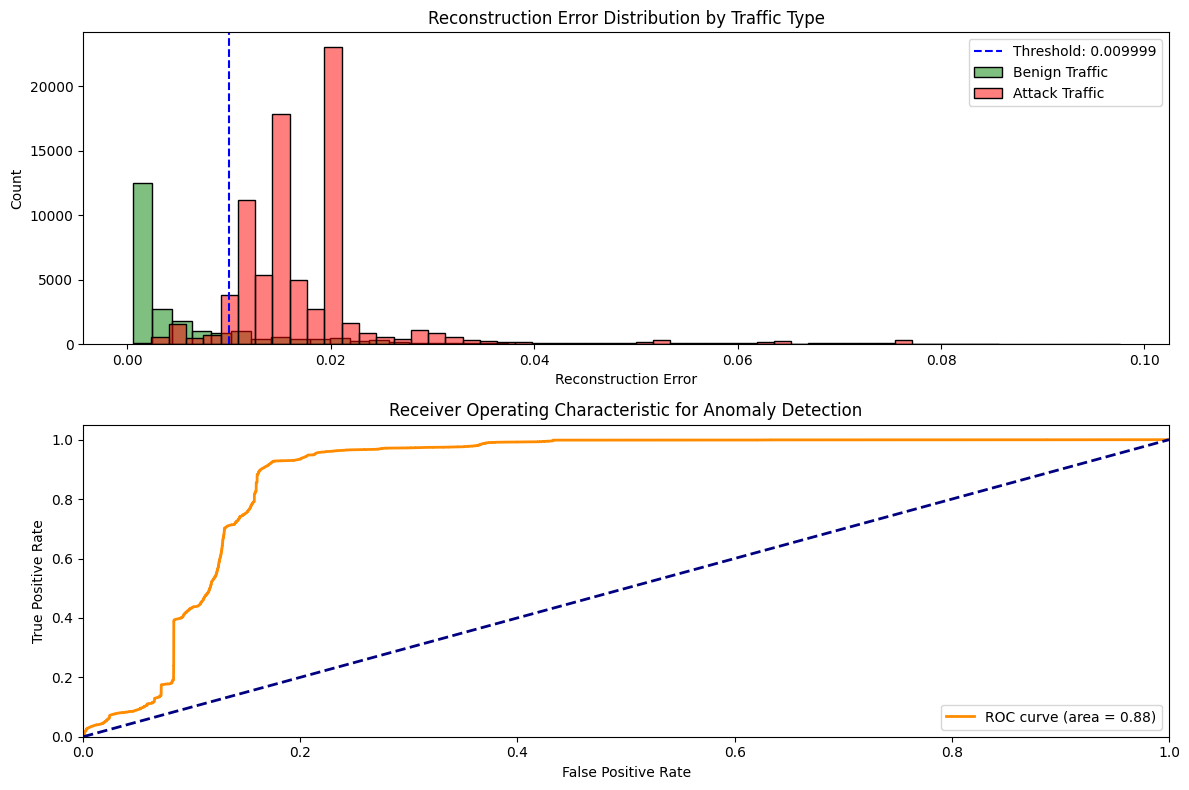

In [48]:
# Visualize reconstruction error distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.histplot(test_reconstruction_errors[benign_idx_test], bins=50, color='green', alpha=0.5, label='Benign Traffic')
sns.histplot(test_reconstruction_errors[y_test_binary == 1], bins=50, color='red', alpha=0.5, label='Attack Traffic')
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.title('Reconstruction Error Distribution by Traffic Type')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()

plt.subplot(2, 1, 2)
fpr, tpr, _ = roc_curve(y_test_binary, test_reconstruction_errors)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Anomaly Detection')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('reconstruction_error_analysis.png')
plt.show()

In [49]:
print("Preparing data for attack type classification...")
attack_idx_train = np.where(y_train_binary == 1)[0]
attack_idx_test = np.where(y_test_binary == 1)[0]

# Use original features for attack classification instead of encoded features
X_train_attacks = X_train[attack_idx_train]
y_train_attacks = y_train_multi[attack_idx_train]
y_train_attacks_onehot = y_train_onehot[attack_idx_train]

X_test_attacks = X_test[attack_idx_test]
y_test_attacks = y_test_multi[attack_idx_test]
y_test_attacks_onehot = y_test_onehot[attack_idx_test]

print(f"Attack classification training data shape: {X_train_attacks.shape}")
print(f"Attack classification test data shape: {X_test_attacks.shape}")


Preparing data for attack type classification...
Attack classification training data shape: (246074, 77)
Attack classification test data shape: (82025, 77)


In [50]:
# Cell: Train deep neural network classifier on attack data
print("Training deep neural network classifier on original features...")
classifier = create_classifier(
    input_dim=X_train_attacks.shape[1],
    num_classes=n_classes,
    hidden_layers=[256, 128, 64],
    dropout_rate=0.3
)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

classifier.summary()
classifier_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_classifier_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]


Training deep neural network classifier on original features...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 256)                 │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,822 (249.30 KB)

 Trainable params: 62,926 (245.80 KB)

 Non-trainable params: 896 (3.50 KB)

In [51]:
# Cell: Fit DNN classifier
history_classifier = classifier.fit(
    X_train_attacks, y_train_attacks_onehot,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=classifier_callbacks,
    verbose=1
)

Epoch 1/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8148 - loss: 0.6637
Epoch 1: val_accuracy improved from -inf to 0.89771, saving model to best_classifier_model.keras
769/769 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8149 - loss: 0.6633 - val_accuracy: 0.8977 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 2/50
757/769 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9034 - loss: 0.2598
Epoch 2: val_accuracy did not improve from 0.89771
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9034 - loss: 0.2597 - val_accuracy: 0.8344 - val_loss: 0.4226 - learning_rate: 0.0010
Epoch 3/50
763/769 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9092 - loss: 0.2369
Epoch 3: val_accuracy did not improve from 0.89771
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9092 - loss: 0.2369 - val_accuracy: 0.6331 - val_loss: 2.3357 - learning_rate: 0.0010
Epoch 4/50
767/769 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9230 - loss: 0.2043
Epoch 4: val_accuracy did not imp

In [52]:
# Evaluate DNN classifier
print("\nEvaluating DNN classifier...")
y_pred_proba_dnn = classifier.predict(X_test_attacks)
y_pred_dnn = np.argmax(y_pred_proba_dnn, axis=1)
y_true = y_test_attacks

accuracy_dnn = accuracy_score(y_true, y_pred_dnn)
precision_dnn = precision_score(y_true, y_pred_dnn, average='weighted')
recall_dnn = recall_score(y_true, y_pred_dnn, average='weighted')
f1_dnn = f1_score(y_true, y_pred_dnn, average='weighted')

print(f"DNN Classifier Performance:")
print(f"Accuracy: {accuracy_dnn:.4f}")
print(f"Precision: {precision_dnn:.4f}")
print(f"Recall: {recall_dnn:.4f}")
print(f"F1 Score: {f1_dnn:.4f}")



Evaluating DNN classifier...
2564/2564 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
DNN Classifier Performance:
Accuracy: 0.9355
Precision: 0.9186
Recall: 0.9355
F1 Score: 0.9231


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


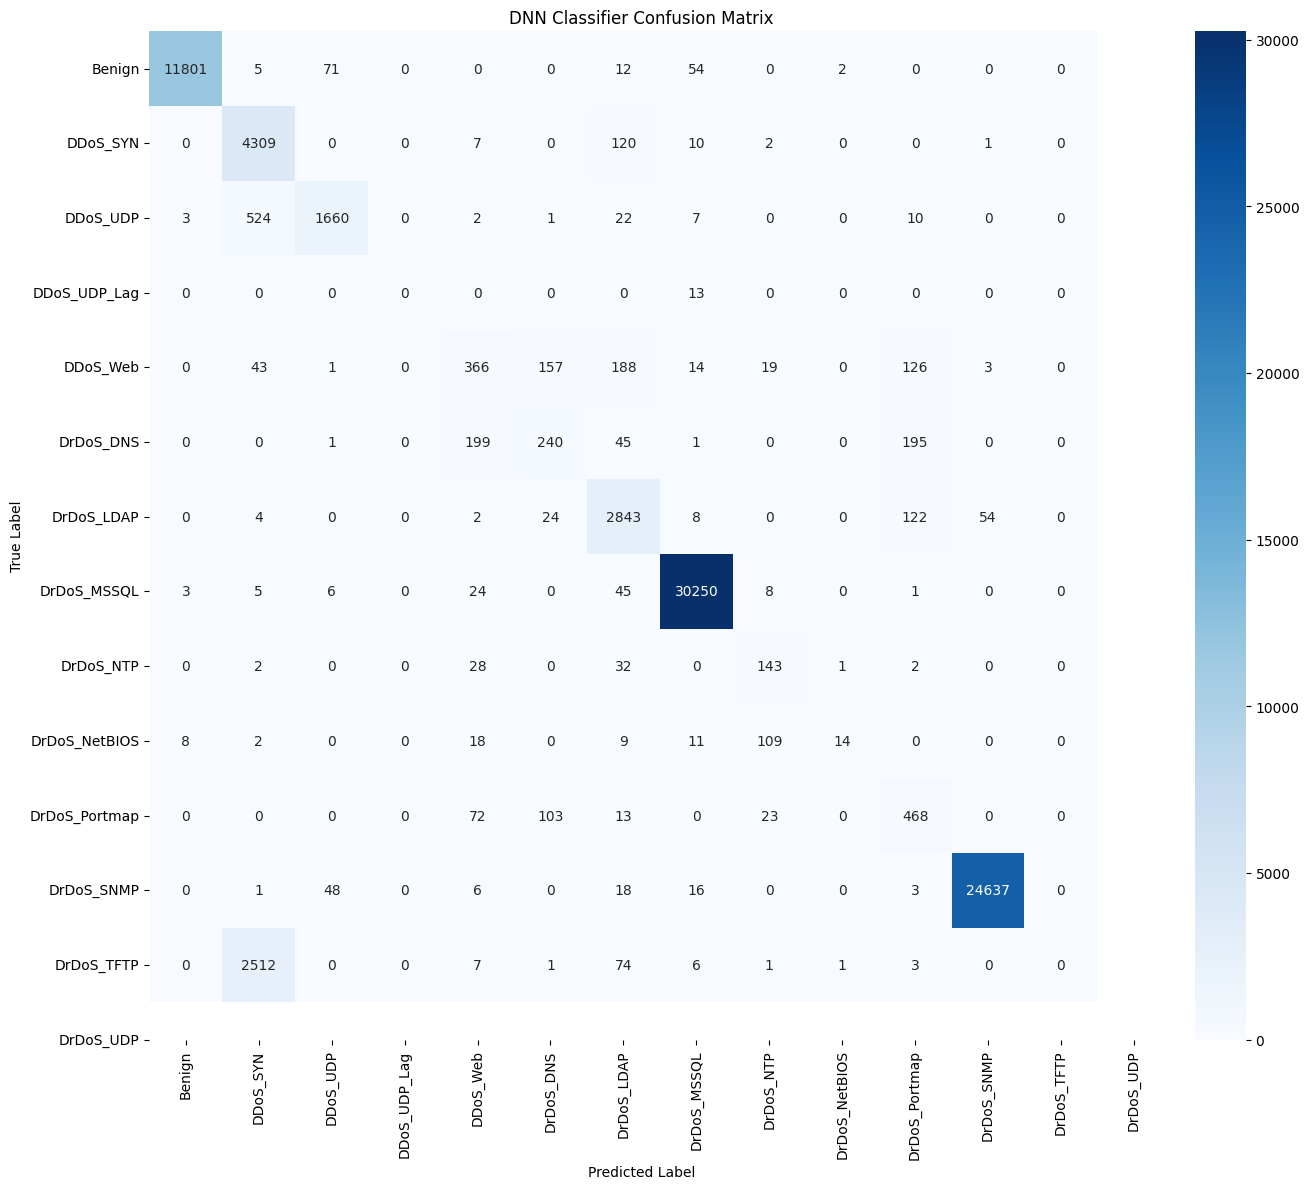

In [53]:
# Cell: Create confusion matrices
# Create confusion matrix for DNN
cm_dnn = confusion_matrix(y_true, y_pred_dnn)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues')
plt.title('DNN Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(label_encoder.classes_)) + 0.5, label_encoder.classes_, rotation=90)
plt.yticks(np.arange(len(label_encoder.classes_)) + 0.5, label_encoder.classes_, rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_dnn.png')
plt.show()


In [54]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [56]:

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.joblib')

# Save the feature columns 
joblib.dump(feature_cols, 'feature_cols.joblib')

# Save the anomaly threshold
np.save('anomaly_threshold.npy', threshold)

# Save the autoencoder model
autoencoder.save('autoencoder_model.keras')

# Save the classifier model
classifier.save('classifier_model.keras')

print("All models and preprocessing components saved successfully!")

All models and preprocessing components saved successfully!
